In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import random
import json
import os

# Amount of images needed

In [2]:
def get_scores(df: pd.DataFrame, step: float, end: float, start: float, drop_cols: list, unique_images, n_jobs) -> list:
    scores = {}
    last_n_images = None
    for perc in np.arange(start, end, step):
        sample_size = int(len(unique_images) * perc)
        if sample_size == 0:
            scores[perc] = [np.nan, 0]
            continue
        if sample_size == last_n_images:
            scores[perc] = [np.nan, last_n_images]  # Skip if same as previous
            continue
        last_n_images = sample_size
        selected_images = random.sample(list(unique_images), sample_size)
        df_train = df[df['sample_id'].isin(selected_images)].drop(columns=drop_cols)
        
        X_train = df_train.drop(columns=['cell_type'])
        y_train = df_train['cell_type']
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)

        xgb = XGBClassifier(objective='multi:softmax', n_jobs=n_jobs)
        xgb.fit(X_train, y_train)

        true = df['cell_type']
        df_predict = df.drop(columns=drop_cols + ['cell_type'])
        pred = xgb.predict(df_predict)
        pred = label_encoder.inverse_transform(pred)
        score = f1_score(pred, true, average='macro')
        scores[perc] = [score, sample_size]
    del df_train, X_train, y_train, df_predict, pred, true, xgb
    return scores

def get_cell_scores(df: pd.DataFrame, step: int, end: int, start: int, drop_cols: list, n_jobs: int, random_state: int = 42) -> list:
    scores = []
    for perc in np.arange(start, end, step):
        df_train = df.sample(n=perc, random_state=random_state).drop(columns=drop_cols)

        X_train = df_train.drop(columns=['cell_type'])
        y_train = df_train['cell_type']
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)

        xgb = XGBClassifier(objective='multi:softmax', n_jobs=n_jobs)
        xgb.fit(X_train, y_train)

        true = df['cell_type']
        df_predict = df.drop(columns=drop_cols + ['cell_type'])
        pred = xgb.predict(df_predict)
        pred = label_encoder.inverse_transform(pred)
        score = f1_score(pred, true, average='macro')
        scores.append(score)
    del df_train, X_train, y_train, df_predict, pred, true, xgb
    return scores


In [3]:
df_score = pd.DataFrame(index=np.arange(0.01, 0.51, 0.01) * 100, columns=['n_images_IMMUcan','n_images_cHL_2_MIBI', 'perc_images_IMMUcan', 'perc_images_cHL_2_MIBI', 'f1_score_IMMUcan', 'f1_score_cHL_2_MIBI'])

In [4]:
df_immu = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')
unique_images_immu = df_immu['sample_id'].unique()
scores = get_scores(df_immu, 0.01, 0.51, 0.01, 
                    ['image', 'sample_id', 'cell_id', 'x', 'y', 'width_px',
                     'height_px', 'cell_labels', 'level_1_cell_type', 'level_2_cell_type'], 
                    unique_images_immu, 6)

In [5]:
df_score['f1_score_IMMUcan'] = [first for first, _ in scores.values()]
df_score['n_images_IMMUcan'] = [second for _, second in scores.values()]
df_score['perc_images_IMMUcan'] = df_score['n_images_IMMUcan'] / df_immu['sample_id'].nunique()
df_score

,n_images_IMMUcan,n_images_cHL_2_MIBI,perc_images_IMMUcan,perc_images_cHL_2_MIBI,f1_score_IMMUcan,f1_score_cHL_2_MIBI
1.0,1,NaN,0.005587,NaN,0.503396,NaN
2.0,3,NaN,0.016760,NaN,0.833177,NaN
3.0,5,NaN,0.027933,NaN,0.831028,NaN
4.0,7,NaN,0.039106,NaN,0.823376,NaN
5.0,8,NaN,0.044693,NaN,0.864932,NaN
6.0,10,NaN,0.055866,NaN,0.864868,NaN
7.0,12,NaN,0.067039,NaN,0.866942,NaN
8.0,14,NaN,0.078212,NaN,0.865998,NaN
9.0,16,NaN,0.089385,NaN,0.869907,NaN
10.0,17,NaN,0.094972,NaN,0.887364,NaN


In [6]:
df_cHL_2 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')
unique_images_cHL_2 = df_cHL_2['sample_id'].unique()
scores_cHL_2 = get_scores(df_cHL_2, 0.01, 0.51, 0.01, 
                    ['sample_id', 'cell_id', 'x', 'y', 'level_1_cell_type', 'level_2_cell_type'], 
                    unique_images_cHL_2, n_jobs=6)

In [7]:
df_score['f1_score_cHL_2_MIBI'] = [first for first, _ in scores_cHL_2.values()]
df_score['n_images_cHL_2_MIBI'] = [second for _, second in scores_cHL_2.values()]
df_score['perc_images_cHL_2_MIBI'] = df_score['n_images_cHL_2_MIBI'] / df_cHL_2['sample_id'].nunique()
df_score

,n_images_IMMUcan,n_images_cHL_2_MIBI,perc_images_IMMUcan,perc_images_cHL_2_MIBI,f1_score_IMMUcan,f1_score_cHL_2_MIBI
1.0,1,0,0.005587,0.000000,0.503396,NaN
2.0,3,0,0.016760,0.000000,0.833177,NaN
3.0,5,0,0.027933,0.000000,0.831028,NaN
4.0,7,0,0.039106,0.000000,0.823376,NaN
5.0,8,0,0.044693,0.000000,0.864932,NaN
6.0,10,0,0.055866,0.000000,0.864868,NaN
7.0,12,0,0.067039,0.000000,0.866942,NaN
8.0,14,0,0.078212,0.000000,0.865998,NaN
9.0,16,0,0.089385,0.000000,0.869907,NaN
10.0,17,0,0.094972,0.000000,0.887364,NaN


In [9]:
with open("/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/github/pheno_benchmark_small/src/plotting/dataset_colors.json", "r") as f:
    color_mapping_datasets = json.load(f)

In [10]:
color_mapping_datasets

{'cHL_2_MIBI': [0.047058823529411764, 0.44313725490196076, 1.0],
 'IMMUcan': [0.792156862745098, 0.1568627450980392, 0.0]}

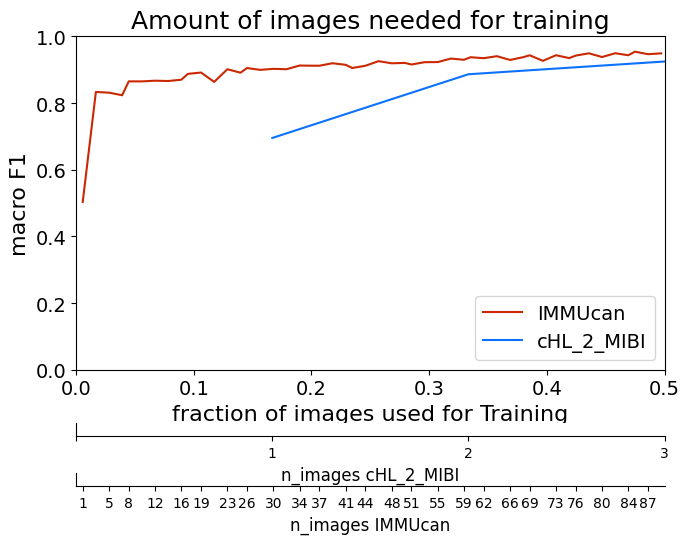

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 6))
sns.lineplot(data=df_score, x='perc_images_IMMUcan', y='f1_score_IMMUcan', ax=ax1, label='IMMUcan', color=color_mapping_datasets['IMMUcan'])
sns.lineplot(data=df_score, x='perc_images_cHL_2_MIBI', y='f1_score_cHL_2_MIBI', ax=ax1, label='cHL_2_MIBI', color=color_mapping_datasets['cHL_2_MIBI'])
ax1.set_xlabel('fraction of images used for Training', fontsize=16)
ax1.set_ylabel('macro F1', fontsize=16)
ax1.set_xlim(0, 0.5)
plt.ylim(0, 1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax1.set_title('Amount of images needed for training', fontsize=18)


ax2 = ax1.inset_axes([0, -0.35, 1, 0.04], transform=ax1.transAxes)
positions_immu = sorted(df_score['perc_images_IMMUcan'].unique())
labels_immu = []
for pos in positions_immu:
    
    subset = df_score[df_score['perc_images_IMMUcan'] == pos]
    val = subset['n_images_IMMUcan'].iloc[-1] if not subset.empty else ''
    labels_immu.append(str(int(val)) if val != 0 else '')
positions_immu = positions_immu[::2]
labels_immu = labels_immu[::2]
ax2.set_xticks(positions_immu)
ax2.set_xticklabels(labels_immu, fontsize=10)
ax2.set_xlim(ax1.get_xlim())
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('n_images IMMUcan', fontsize=12)

ax3 = ax1.inset_axes([0, -0.20, 1, 0.04], transform=ax1.transAxes)
positions_cHL = sorted(df_score['perc_images_cHL_2_MIBI'].unique())
labels_cHL = []
for pos in positions_cHL:
    
    subset = df_score[df_score['perc_images_cHL_2_MIBI'] == pos]
    val = subset['n_images_cHL_2_MIBI'].iloc[-1] if not subset.empty else ''
    labels_cHL.append(str(int(val)) if val != 0 else '')


ax3.set_xticks(positions_cHL)
ax3.set_xticklabels(labels_cHL, fontsize=10)
ax3.set_xlim(ax1.get_xlim())
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('n_images cHL_2_MIBI', fontsize=12)

ax1.legend(fontsize=14, loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join('..', 'plotting', 'figure_plots', 'amount_of_images_needed_for_training.svg'), dpi=300)

# AMount of cells needed

In [16]:
df_immu.sample(n=1000, random_state=42)

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,area,major_axis_length,minor_axis_length,eccentricity,width_px,height_px,cell_labels,level_1_cell_type,level_2_cell_type,cell_type
45884,0.181487,1.468532,1.098321,2.704713,0.336340,4.180573,0.660973,0.816860,0.233966,2.575802,...,56,9.329609,7.642472,0.573561,600,600,M2_Macrophage,Immune,Myeloid_immune,M2_Macrophage
403346,0.410202,3.650314,0.457329,0.829509,0.865323,3.486302,0.958524,3.276648,0.991073,0.361186,...,117,12.765977,11.682949,0.403084,600,600,Cancer,Cancer,Cancer,Cancer
10009,0.143307,1.607952,0.722119,0.312063,0.051015,2.480044,0.160082,0.645419,0.152475,0.178953,...,51,9.003245,7.310098,0.583740,600,600,Cancer,undefined,undefined,undefined
248524,0.160276,2.419403,0.629107,0.186247,0.295846,0.428391,0.626501,0.536146,0.663741,0.116304,...,146,15.618596,12.330934,0.613746,600,600,Cancer,Cancer,Cancer,Cancer
294357,0.117746,1.865740,0.070400,3.415496,0.441182,4.070616,1.534379,0.534353,0.494438,2.718690,...,196,19.393715,12.907886,0.746335,600,600,M2_Macrophage,Cancer,Cancer,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90746,0.166719,2.478895,0.017082,1.315190,0.307601,4.208091,0.224103,2.980042,0.340879,0.157878,...,106,12.767859,10.577988,0.560010,600,600,Dendritic_cell,Cancer,Cancer,Cancer
242091,0.478762,3.297848,0.034387,0.105367,0.031495,1.033770,0.487022,0.090257,1.696301,0.716681,...,21,7.159237,3.660381,0.859414,600,600,B_cell,Immune,Lymphoid_immune,B_cell
201332,0.199466,2.931711,0.000000,0.552056,0.306514,2.872915,2.007350,1.280715,0.761776,1.865221,...,27,6.349417,5.469744,0.507832,600,600,CD4+_T_cell,Immune,Lymphoid_immune,CD4+_T_cell
215935,0.174792,1.430749,1.613905,0.408363,1.151664,0.982781,1.251920,0.139461,0.421174,0.085615,...,75,16.936892,5.710249,0.941451,600,600,unlabelled,Immune,Lymphoid_immune,Plasma_cell


In [17]:
df_immu = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')
cells_immu = get_cell_scores(df_immu, step=500, end=60001, start=500, drop_cols=['image', 'sample_id', 'cell_id', 'x', 'y', 'width_px',
                     'height_px', 'cell_labels', 'level_1_cell_type', 'level_2_cell_type'], n_jobs=6)

In [18]:
df_cHL_2 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')
cells_cHL2 = get_cell_scores(df_cHL_2, step=500, end=60001, start=500, drop_cols=['sample_id', 'cell_id', 'x', 'y', 'level_1_cell_type', 'level_2_cell_type'], n_jobs=6)

In [19]:
df_score = pd.DataFrame(index=np.arange(500, 60001, 500), columns=['f1_score_IMMUcan', 'f1_score_cHL_2_MIBI'])

In [20]:
df_score['f1_score_IMMUcan'] = cells_immu
df_score['f1_score_cHL_2_MIBI'] = cells_cHL2
df_score

,f1_score_IMMUcan,f1_score_cHL_2_MIBI
500,0.743271,0.666106
1000,0.791991,0.723740
1500,0.803441,0.744263
2000,0.818495,0.758416
2500,0.834183,0.771908
...,...,...
58000,0.927956,0.905253
58500,0.928527,0.905291
59000,0.928314,0.905545
59500,0.929078,0.906395


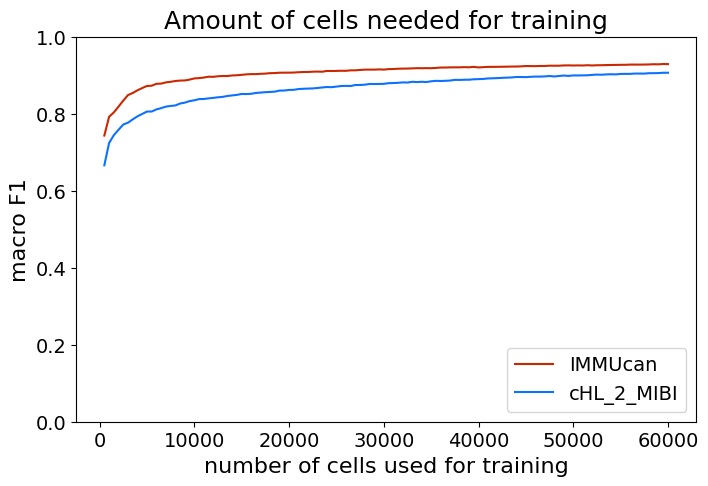

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=df_score, x=df_score.index, y='f1_score_IMMUcan', ax=ax, label='IMMUcan', color = color_mapping_datasets['IMMUcan'])
sns.lineplot(data=df_score, x=df_score.index, y='f1_score_cHL_2_MIBI', ax=ax, label='cHL_2_MIBI', color = color_mapping_datasets['cHL_2_MIBI'])
ax.set_xlabel('number of cells used for training', fontsize=16)
ax.set_ylabel('macro F1', fontsize=16)
plt.ylim(0, 1)
#ax.set_xscale('log')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_title('Amount of cells needed for training', fontsize=18)
ax.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join('..', 'plotting', 'figure_plots', 'amount_of_cells_needed_for_training.svg'), dpi=300)
plt.show()